# High influx filter

This notebook shows the "high influx filter" to detect unrealistically high rainfall records in private weather station data (PWS) based on data from neighboring sensors.

The original R code stems from https://github.com/LottedeVos/PWSQC/. 

Publication:
de Vos, L. W., Leijnse, H., Overeem, A., & Uijlenhoet, R. (2019). Quality control for crowdsourced personal weather stations to enable operational rainfall monitoring. _Geophysical Research Letters_, 46(15), 8820-8829.

The idea of the filter is to evaluate rainfall data of a sensor (in our case here a PWS) in comparison to a reference, which in case of a PWS network stems from neighboring sensors, and flag time steps where the stations is reporting unrealistically high rainfall rainfall. This can be caused by, for example, people pouring liquids through the rain gauge for cleaning, handling of the device with tilting movements, or sprinklers in the vicinity.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import packages

import matplotlib.pyplot as plt
import poligrain as plg
import xarray as xr

import pypwsqc as pws

## Load example data

In this example we use an open PWS dataset from Amsterdam, called the "AMS PWS" dataset. The data set can be downloaded locally by running the curl-command in the cell below.

In [3]:
!curl -OL https://github.com/OpenSenseAction/OS_data_format_conventions/raw/main/notebooks/data/OpenSense_PWS_example_format_data.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 5687k  100 5687k    0     0  2056k      0  0:00:02  0:00:02 --:--:-- 2529k50k      0  0:00:03  0:00:01  0:00:02 2516k


In [4]:
# read PWS data with xarray
ds_pws = xr.open_dataset("OpenSense_PWS_example_format_data.nc")

# view data
ds_pws

<xarray.Dataset>
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    latitude   (id) float64 ...
    longitude  (id) float64 ...
Data variables:
    rainfall   (id, time) float64 ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

## Find neighboring stations

### Reproject coordinates to metric projection to allow for distance calculations 

Second, we reproject the coordinates to a local metric coordinate reference system, in the Amsterdam case EPSG:25832. This can be done with the function `spatial.project_point_coordinates` in the `poligrain`package. 

In [5]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    x=ds_pws.longitude, y=ds_pws.latitude, target_projection="EPSG:25832"
)

### Get distances and IDs of neighboring stations

We use `poligrain` to do the calculation. It returns the results in a conventient `xarray.Dataset`.

The selected maximum range to the neighbors depends on the use case and area of interest. In this example we use 10'000 meters.

Note that `max_distance` uses the units that are defined by the `x` and `y` coordinates of the station locations.

In [6]:
max_distance = 10e3
n_closest = 130

ds_neighbors = plg.spatial.get_closest_points_to_point(
    ds_points=ds_pws,
    ds_points_neighbors=ds_pws,
    max_distance=max_distance,
    n_closest=n_closest,
)

In [7]:
ds_neighbors

<xarray.Dataset>
Dimensions:      (id: 134, n_closest: 130)
Coordinates:
  * id           (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
Dimensions without coordinates: n_closest
Data variables:
    distance     (id, n_closest) float64 0.0 518.8 532.0 ... inf inf inf
    neighbor_id  (id, n_closest) object 'ams1' 'ams2' 'ams3' ... None None None

Let's plot the resulting distance of the neighbors. As you can see, they are sorted by increasing distance.

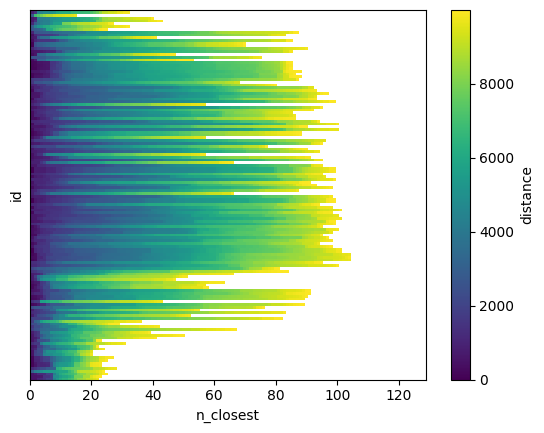

In [8]:
ds_neighbors.distance.plot()
plt.gca().set_yticks([]);

If you want, you can select a smaller `max_distance` again after the calculation of the neighbors. This might be handy if you want to try out different threshold for processing the data.

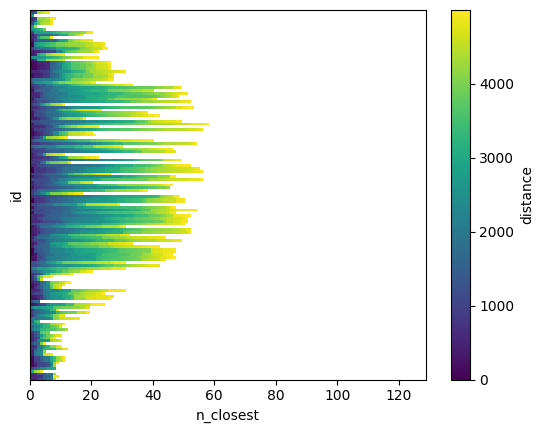

In [9]:
ds_neighbors.distance.where(ds_neighbors.distance < 5e3).plot()
plt.gca().set_yticks([]);

### old version with distance matrix, for comparison (to be removed)


In [10]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

In [11]:
pws_id = "ams2"

distance_matrix.id.data[distance_matrix.sel(id=pws_id) < max_distance]

array(['ams1', 'ams2', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8',
       'ams9', 'ams10', 'ams11', 'ams12', 'ams13', 'ams14', 'ams15',
       'ams16', 'ams17', 'ams19', 'ams20', 'ams21', 'ams23', 'ams24',
       'ams26', 'ams34'], dtype='<U6')

In [12]:
ds_neighbors.sel(id=pws_id).neighbor_id.dropna(dim="n_closest")

<xarray.DataArray 'neighbor_id' (n_closest: 24)>
array(['ams2', 'ams1', 'ams6', 'ams7', 'ams3', 'ams8', 'ams9', 'ams5',
       'ams12', 'ams4', 'ams13', 'ams15', 'ams10', 'ams11', 'ams20',
       'ams24', 'ams19', 'ams21', 'ams26', 'ams23', 'ams17', 'ams14',
       'ams16', 'ams34'], dtype=object)
Coordinates:
    id       <U6 'ams2'
Dimensions without coordinates: n_closest

In [13]:
foo = set(distance_matrix.id.data[distance_matrix.sel(id=pws_id) < max_distance])

bar = set(ds_neighbors.sel(id=pws_id).neighbor_id.dropna(dim="n_closest").data)

foo == bar

True

### Calculate number of neighbours reporting rainfall per timestep
Now we can calculate number of neighbours reporting rainfall per timestep and save it in the data array `nbrs_not_nan`.

In [14]:
%%time
ds_pws = ds_pws.load()

nbrs_not_nan = []

for pws_id in ds_pws.id.data:
    neighbor_ids = ds_neighbors.sel(id=pws_id).neighbor_id.dropna(dim="n_closest").data
    N = ds_pws.rainfall.sel(id=neighbor_ids).isnull().sum(dim="id")
    nbrs_not_nan.append(N)

ds_pws["nbrs_not_nan"] = xr.concat(nbrs_not_nan, dim="id")

CPU times: user 8.07 s, sys: 4.58 s, total: 12.6 s
Wall time: 12.7 s


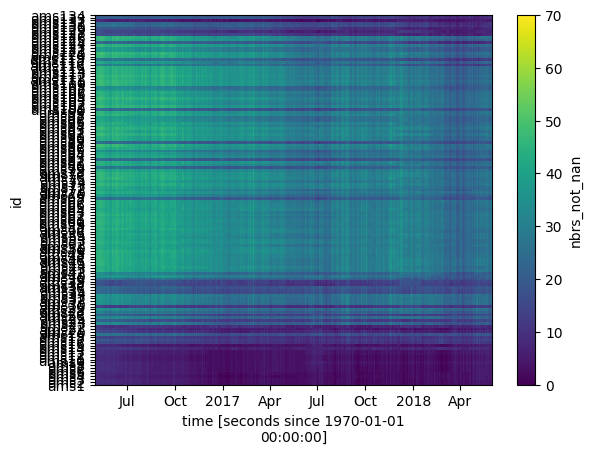

In [15]:
ds_pws.nbrs_not_nan.plot()

In [16]:
%%time
ds_pws = ds_pws.load()

nbrs_not_nan = []

for pws_id in ds_pws.id.data:
    neighbor_ids = distance_matrix.id.data[
        distance_matrix.sel(id=pws_id) < max_distance
    ]
    N = ds_pws.rainfall.sel(id=neighbor_ids).isnull().sum(dim="id")
    nbrs_not_nan.append(N)

ds_pws["nbrs_not_nan"] = xr.concat(nbrs_not_nan, dim="id")

CPU times: user 7.89 s, sys: 4.58 s, total: 12.5 s
Wall time: 12.5 s


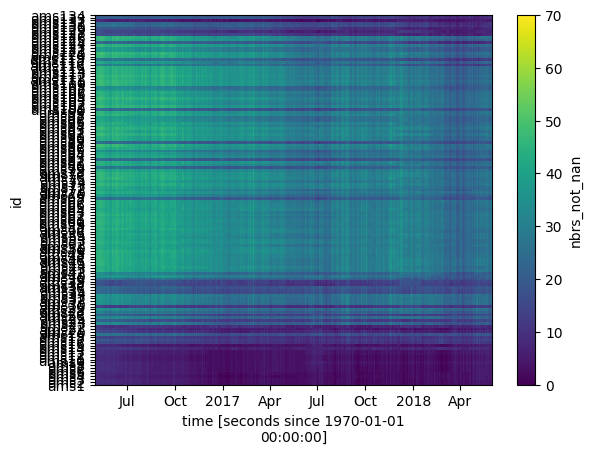

In [17]:
ds_pws.nbrs_not_nan.plot()

# !!!! Below is code I have not yet updated!!!!

I still runs with the distance matrix

## Calculate reference

The default reference of the filter is to compare the observed rainfall of a given station with the median rainfall from all stations within range `max_distance` (i.e. `reference`). If the median is below the threshold value `HIthresA`, the HI flag for the station is set to 1 (i.e. high influx) for rainfall amounts above threshold `HIthresB`. When the surrounding stations report moderate to heavy rainfall, the threshold becomes variable: for a median of `HIthresA` or higher, the station's HI flag is set to 1 when its measurements exceed the median times `HIthresB/HIthresA`. 

In [ ]:
%%time

reference = []

for pws_id in ds_pws.id.data:
    neighbor_ids = distance_matrix.id.data[
        distance_matrix.sel(id=pws_id) < max_distance
    ]
    median = ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id")
    reference.append(median)

In [ ]:
ds_pws["reference"] = xr.concat(reference, dim="id")

# view data
ds_pws

## (Faulty Zeroes filter)

Conditions for raising Faulty Zeroes flag:

* FZflag is not -1
* Median rainfall of neighbouring stations within range `max_distance` is larger than zero for at least `nint` time intervals while the station itself reports zero rainfall.

The FZ flag remains 1 until the station reports nonzero rainfall. For settings for parameter `nint`, see table 1 in https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731 

In [ ]:
# fz_flag = pws.flagging.fz_filter(
#    pws_data=ds_pws.rainfall,
#    reference=ds_pws.reference,
#    nint=3
# )

In [ ]:
# ds_pws["fz_flag"]= fz_flag

## High Influx filter

Conditions for raising High Influx flag:

* If median below threshold `ϕA`, then high influx if rainfall above threshold `ϕB`
* If median above `ϕA`, then high influx if rainfall exceeds median times `ϕB`/`ϕA`

Filter cannot be applied if less than `nstat` neighbours are reporting data (HI flag is set to -1)

For settings for parameter `ϕA`, `ϕB` and `nstat`, see table 1 in https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731

In [ ]:
hi_flag = pws.flagging.hi_filter(
    pws_data=ds_pws.rainfall,
    nbrs_not_nan=ds_pws.nbrs_not_nan,
    reference=ds_pws.reference,
    hi_thres_a=0.4,
    hi_thres_b=0.2,
    n_stat=5,
)

In [ ]:
ds_pws["hi_flag"] = hi_flag

Now we have a dataset with hi-flags per time step!

In [ ]:
ds_pws